# Keyword Matching Models

## Overview

This notebook explores different models used for keyword matching, focusing on three specific methods: TF-IDF, N-grams, and BM25. Each model offers a unique approach to text analysis, helping in various ways to enhance the relevance and precision of keyword extraction from documents.

## Models Description

### TF-IDF (Term Frequency-Inverse Document Frequency)
TF-IDF weighs the frequency of a word in a document against its rarity across all documents. This method highlights words unique to the context of each document. Even if a word occurs frequently, TF-IDF diminishes its weight if commonly found elsewhere, prioritizing terms distinctively significant to each specific document.

### N-grams
N-grams model captures sequences of 'n' words within the text to maintain the context. For instance, setting the `ngram_range` to (1,2) allows the vectorizer to consider both unigrams (single words) and bigrams (two-word sequences). This method ensures that phrases like "hot dog" are recognized in their culinary context, rather than treating "hot" and "dog" as unrelated terms.

### BM25
BM25 is an advanced version of TF-IDF that includes adjustments for document length and term saturation. It effectively balances term frequency with the length of the document, ensuring that frequent terms in long documents do not overshadow shorter but more relevant documents. For example, the term "revolution" would be weighted differently in a lengthy article on the "French Revolution" compared to a short piece on a "Dance Revolution."


Let us begin by importing the necessary libraries and loading the dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# parallel processing
import dask.dataframe as dd
from dask import delayed

from sklearn.preprocessing import MinMaxScaler
from rank_bm25 import BM25Okapi

import random
from sklearn.model_selection import KFold

/Users/tammiekoh/Documents/projects/wikipedia-analysis/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
qns_answers = pd.read_csv('data/updated_qns_answers.csv')

In [3]:
keyword_matching_dataset = qns_answers.copy()

keyword_matching_dataset.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster
0,did the people of gibraltar vote to remain pa...,58,Gibraltar,"([('the united kingdom', 'GPE'), ('2002', 'DAT...",62.68,people gibraltar vote remain part united kingd...,15222,https://simple.wikipedia.org/wiki/Gibraltar,Gibraltar is an Overseas Territory of the Unit...,gibraltar overseas territory united kingdom me...,192.0
1,which country uses the franc as its official ...,55,Currency,"([], [(' ', 'dep', 'which'), ('which', 'det', ...",53.88,country us franc official currency,2140,https://simple.wikipedia.org/wiki/Currency,Currency is the unit of money used by the peop...,currency unit money used people country union ...,127.0
2,which of these old communist parties no longe...,52,List of communist parties,"([('communist', 'NORP'), ('today', 'DATE')], [...",69.79,old communist party longer exists today,4402,https://simple.wikipedia.org/wiki/List%20of%20...,There are a number of communist parties around...,number communist party around world world hist...,121.0
3,a patient has a terminal illness and wants to ...,65,Medical ethics,"([], [('a', 'det', 'patient'), ('patient', 'ns...",66.23,patient terminal illness want end life family ...,13938,https://simple.wikipedia.org/wiki/Medical%20et...,Medical ethics is the set of ethical rules tha...,medical ethic set ethical rule doctor follow i...,117.0
4,"according to plato, what are the three types o...",55,The Republic,"([('three', 'CARDINAL')], [('according', 'prep...",71.14,according plato three type people society made,13148,https://simple.wikipedia.org/wiki/The%20Republic,The Republic is a book by Plato. It was finish...,republic book plato finished bc asks question ...,117.0


In [4]:
keyword_matching_dataset.isna().sum()


question                 0
points                   0
article                  0
nlp_analysis             0
readability_score        0
preprocessed_question    1
id                       0
url                      0
article_text             0
preprocessed_text        0
cluster                  0
dtype: int64

The `keyword_matching_dataset` DataFrame shows the number of missing values for each column, indicating that the `preprocessed_question` column has 1 missing value while all other columns have no missing entries.

## Strategy 1: Question to Cluster Matching

In the `keyword_matching_dataset`, we first address data quality by removing rows where the 'preprocessed_question' or 'preprocessed_text' columns contain NaN values. This ensures that the subsequent text processing and vectorization operate on complete data. After cleaning, we use the `groupby` method to aggregate the preprocessed text of articles by their cluster, creating a single document per cluster. This aggregated data is then merged back into the dataset.

We employ the TF-IDF Vectorizer for text vectorization, which transforms both the questions and the cluster documents into a numerical format that reflects the importance of words within the text, relative to their frequency in the entire corpus. This transformation facilitates the calculation of cosine similarity between each question and its corresponding cluster document. Cosine similarity is used here due to its robustness in handling different lengths of texts and its effectiveness in high-dimensional spaces typical of text data.

With regards to why we use cosine similarity, cosine similarity measures the orientation, not the magnitude, of vector representations of text, making it particularly useful for comparing documents of varying lengths and contents. The similarity scores range from -1 to 1, where 1 indicates identical directionality or high similarity, 0 indicates no similarity, and -1 indicates completely opposite meanings. This intuitive scale helps in straightforward interpretation of the results, assessing how closely each question aligns semantically with the contents of its cluster. This method not only highlights the relevance of questions within their clusters but also emphasizes the practical application of cosine similarity in overcoming the challenges posed by the high-dimensional nature of text data.

In [5]:
# Drop rows where 'preprocessed_question' or 'preprocessed_text' contain NaN values
keyword_matching_dataset = keyword_matching_dataset.dropna(subset=['preprocessed_question', 'preprocessed_text'])

# Aggregate the preprocessed text of articles by their cluster to create a single document per cluster
cluster_documents = keyword_matching_dataset.groupby('cluster')['preprocessed_text'].apply(lambda texts: ' '.join(texts)).reset_index(name='cluster_document')

# Merge this aggregated text back into the cleaned DataFrame on the cluster
keyword_matching_dataset = pd.merge(keyword_matching_dataset, cluster_documents, on='cluster', how='left')

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Combine the questions and the aggregated cluster_document to create a unified feature space
combined_texts = keyword_matching_dataset['preprocessed_question'].tolist() + keyword_matching_dataset['cluster_document'].tolist()

# Fit the vectorizer on the combined set of texts
tfidf_vectorizer.fit(combined_texts)

# Transform both the individual questions and the aggregated cluster documents using the fitted vectorizer
tfidf_matrix_questions = tfidf_vectorizer.transform(keyword_matching_dataset['preprocessed_question'])
tfidf_matrix_cluster_docs = tfidf_vectorizer.transform(keyword_matching_dataset['cluster_document'])


In [6]:
# Calculate cosine similarity between each question and its corresponding cluster document
cosine_similarities = [cosine_similarity(tfidf_matrix_questions[i:i+1], tfidf_matrix_cluster_docs[i:i+1])[0][0] for i in range(len(keyword_matching_dataset))]

# Add the cosine similarity scores to the cleaned DataFrame
keyword_matching_dataset['question_cluster_cosine_similarity'] = pd.Series(cosine_similarities)


In [7]:
print(keyword_matching_dataset.head())

                                            question  points  \
0   did the people of gibraltar vote to remain pa...      58   
1   which country uses the franc as its official ...      55   
2   which of these old communist parties no longe...      52   
3  a patient has a terminal illness and wants to ...      65   
4  according to plato, what are the three types o...      55   

                     article  \
0                  Gibraltar   
1                   Currency   
2  List of communist parties   
3             Medical ethics   
4               The Republic   

                                        nlp_analysis  readability_score  \
0  ([('the united kingdom', 'GPE'), ('2002', 'DAT...              62.68   
1  ([], [(' ', 'dep', 'which'), ('which', 'det', ...              53.88   
2  ([('communist', 'NORP'), ('today', 'DATE')], [...              69.79   
3  ([], [('a', 'det', 'patient'), ('patient', 'ns...              66.23   
4  ([('three', 'CARDINAL')], [('according', 'pr

Next we employ the `n_gram` model to extract keywords from the text. The `n_gram` model captures sequences of 'n' words within the text to maintain the context. For instance, setting the `ngram_range` to (1,2) allows the vectorizer to consider both unigrams (single words) and bigrams (two-word sequences). This method ensures that phrases like "hot dog" are recognized in their culinary context, rather than treating "hot" and "dog" as unrelated terms.

In [8]:
# Initialize a TF-IDF Vectorizer with n-grams
tfidf_vectorizer_ngrams = TfidfVectorizer(ngram_range=(1, 2))

# Fit the vectorizer on the combined set of preprocessed texts with n-grams
tfidf_vectorizer_ngrams.fit(combined_texts)

# Transform both the individual questions and the aggregated cluster documents using the fitted vectorizer
tfidf_matrix_questions_ngrams = tfidf_vectorizer_ngrams.transform(keyword_matching_dataset['preprocessed_question'])
tfidf_matrix_cluster_docs_ngrams = tfidf_vectorizer_ngrams.transform(keyword_matching_dataset['cluster_document'])

In [9]:
# Calculate cosine similarity between each question and its corresponding cluster document
cosine_sim_ngrams = [cosine_similarity(tfidf_matrix_questions_ngrams[i:i+1], tfidf_matrix_cluster_docs_ngrams[i:i+1])[0][0] for i in range(tfidf_matrix_questions_ngrams.shape[0])]

# Add the cosine similarity scores to the DataFrame
keyword_matching_dataset['cosine_sim_with_cluster_ngrams'] = pd.Series(cosine_sim_ngrams)

In [10]:
print(keyword_matching_dataset.head())

                                            question  points  \
0   did the people of gibraltar vote to remain pa...      58   
1   which country uses the franc as its official ...      55   
2   which of these old communist parties no longe...      52   
3  a patient has a terminal illness and wants to ...      65   
4  according to plato, what are the three types o...      55   

                     article  \
0                  Gibraltar   
1                   Currency   
2  List of communist parties   
3             Medical ethics   
4               The Republic   

                                        nlp_analysis  readability_score  \
0  ([('the united kingdom', 'GPE'), ('2002', 'DAT...              62.68   
1  ([], [(' ', 'dep', 'which'), ('which', 'det', ...              53.88   
2  ([('communist', 'NORP'), ('today', 'DATE')], [...              69.79   
3  ([], [('a', 'det', 'patient'), ('patient', 'ns...              66.23   
4  ([('three', 'CARDINAL')], [('according', 'pr

Finally, we use the BM25 model to extract keywords from the text. BM25 is an advanced version of TF-IDF that includes adjustments for document length and term saturation. It effectively balances term frequency with the length of the document, ensuring that frequent terms in long documents do not overshadow shorter but more relevant documents. For example, the term "revolution" would be weighted differently in a lengthy article on the "French Revolution" compared to a short piece on a "Dance Revolution."

In [11]:
# Tokenize the aggregated cluster documents for BM25
tokenized_corpus = [doc.split(" ") for doc in cluster_documents['cluster_document']]
bm25_model = BM25Okapi(tokenized_corpus)

# Create a dictionary to map cluster ID to its index in 'cluster_documents'
cluster_to_index = dict(zip(cluster_documents['cluster'], range(len(cluster_documents))))

# Function to calculate BM25 score for each question against its corresponding cluster document
def calculate_bm25_for_question(question, cluster_id):
    # Ensure the question is tokenized in the same way as the documents
    query_tokens = question.split(" ")
    
    # Retrieve the index of the cluster document based on cluster_id
    doc_index = cluster_to_index.get(cluster_id)
    
    if doc_index is not None:
        # Calculate BM25 scores for the query against all documents
        scores = bm25_model.get_scores(query_tokens)
        # Retrieve the score for the specific cluster document
        return scores[doc_index]
    else:
        # Return a default score or NaN if cluster_id is not found
        return np.nan

# Calculate BM25 scores for each question
keyword_matching_dataset['bm25_score_with_cluster'] = keyword_matching_dataset.apply(lambda row: calculate_bm25_for_question(row['preprocessed_question'], row['cluster']), axis=1)

In [12]:
print(keyword_matching_dataset.head())

                                            question  points  \
0   did the people of gibraltar vote to remain pa...      58   
1   which country uses the franc as its official ...      55   
2   which of these old communist parties no longe...      52   
3  a patient has a terminal illness and wants to ...      65   
4  according to plato, what are the three types o...      55   

                     article  \
0                  Gibraltar   
1                   Currency   
2  List of communist parties   
3             Medical ethics   
4               The Republic   

                                        nlp_analysis  readability_score  \
0  ([('the united kingdom', 'GPE'), ('2002', 'DAT...              62.68   
1  ([], [(' ', 'dep', 'which'), ('which', 'det', ...              53.88   
2  ([('communist', 'NORP'), ('today', 'DATE')], [...              69.79   
3  ([], [('a', 'det', 'patient'), ('patient', 'ns...              66.23   
4  ([('three', 'CARDINAL')], [('according', 'pr

In [13]:
# Reshape the BM25 scores for normalization
bm25_score_reshaped = np.array(keyword_matching_dataset['bm25_score_with_cluster']).reshape(-1, 1)
scaler = MinMaxScaler()
keyword_matching_dataset['norm_bm25_score'] = scaler.fit_transform(bm25_score_reshaped)

In [14]:
keyword_matching_dataset.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cluster_document,question_cluster_cosine_similarity,cosine_sim_with_cluster_ngrams,bm25_score_with_cluster,norm_bm25_score
0,did the people of gibraltar vote to remain pa...,58,Gibraltar,"([('the united kingdom', 'GPE'), ('2002', 'DAT...",62.68,people gibraltar vote remain part united kingd...,15222,https://simple.wikipedia.org/wiki/Gibraltar,Gibraltar is an Overseas Territory of the Unit...,gibraltar overseas territory united kingdom me...,192.0,gibraltar overseas territory united kingdom me...,0.121684,0.050923,19.210182,0.115583
1,which country uses the franc as its official ...,55,Currency,"([], [(' ', 'dep', 'which'), ('which', 'det', ...",53.88,country us franc official currency,2140,https://simple.wikipedia.org/wiki/Currency,Currency is the unit of money used by the peop...,currency unit money used people country union ...,127.0,currency unit money used people country union ...,0.174766,0.047005,18.566181,0.111708
2,which of these old communist parties no longe...,52,List of communist parties,"([('communist', 'NORP'), ('today', 'DATE')], [...",69.79,old communist party longer exists today,4402,https://simple.wikipedia.org/wiki/List%20of%20...,There are a number of communist parties around...,number communist party around world world hist...,121.0,number communist party around world world hist...,0.336633,0.170411,13.436141,0.080842
3,a patient has a terminal illness and wants to ...,65,Medical ethics,"([], [('a', 'det', 'patient'), ('patient', 'ns...",66.23,patient terminal illness want end life family ...,13938,https://simple.wikipedia.org/wiki/Medical%20et...,Medical ethics is the set of ethical rules tha...,medical ethic set ethical rule doctor follow i...,117.0,medical ethic set ethical rule doctor follow i...,0.059725,0.014723,22.605390,0.136011
4,"according to plato, what are the three types o...",55,The Republic,"([('three', 'CARDINAL')], [('according', 'prep...",71.14,according plato three type people society made,13148,https://simple.wikipedia.org/wiki/The%20Republic,The Republic is a book by Plato. It was finish...,republic book plato finished bc asks question ...,117.0,medical ethic set ethical rule doctor follow i...,0.262037,0.078111,23.140734,0.139232


In [15]:
# Calculate the mean similarity scores
mean_sim_tfidf = np.mean(keyword_matching_dataset['question_cluster_cosine_similarity'])
mean_sim_ngrams = np.mean(keyword_matching_dataset['cosine_sim_with_cluster_ngrams'])
mean_norm_bm25_score = np.mean(keyword_matching_dataset['norm_bm25_score'])

print(f"Mean Cosine Similarity (TF-IDF): {mean_sim_tfidf}")
print(f"Mean Cosine Similarity (N-grams): {mean_sim_ngrams}")
print(f"Mean BM25 Score: {mean_norm_bm25_score}")

Mean Cosine Similarity (TF-IDF): 0.11240070701231436
Mean Cosine Similarity (N-grams): 0.0475096268183943
Mean BM25 Score: 0.09819894800763725


The results indicate low performance across the models, with TF-IDF leading at a mean cosine similarity of 0.1124, followed by BM25 and N-grams, suggesting further analysis is needed to understand this distribution.

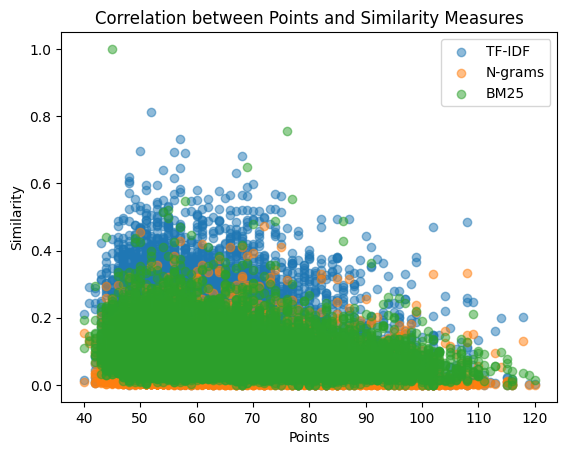

In [16]:
plt.scatter(keyword_matching_dataset['points'], keyword_matching_dataset['question_cluster_cosine_similarity'], label='TF-IDF', alpha=0.5)
plt.scatter(keyword_matching_dataset['points'], keyword_matching_dataset['cosine_sim_with_cluster_ngrams'], label='N-grams', alpha=0.5)
plt.scatter(keyword_matching_dataset['points'], keyword_matching_dataset['norm_bm25_score'], label='BM25', alpha=0.5)

plt.xlabel('Points')
plt.ylabel('Similarity')
plt.title('Correlation between Points and Similarity Measures')
plt.legend()
plt.show()


The scatter plot illustrates a diffuse correlation between points and similarity measures, with TF-IDF slightly outperforming N-grams and more noticeably surpassing BM25, suggesting that adjustments for document length and term saturation may not align well with the structured nature of Wikipedia documents.

In this portion, we will be investigating the type of questions each model performs best and worst on.

In [17]:
high_similarity_threshold = 0.4
low_similarity_threshold = 0.2

In [18]:
# High-points, high-similarity outliers for TF-IDF
high_points_high_tfidf = keyword_matching_dataset[
    (keyword_matching_dataset['points'] > keyword_matching_dataset['points'].quantile(0.9)) & 
    (keyword_matching_dataset['question_cluster_cosine_similarity'] > high_similarity_threshold)
]

# High-points, low-similarity outliers for TF-IDF
high_points_low_tfidf = keyword_matching_dataset[
    (keyword_matching_dataset['points'] > keyword_matching_dataset['points'].quantile(0.9)) & 
    (keyword_matching_dataset['question_cluster_cosine_similarity'] < low_similarity_threshold)
]

# High-points, high-similarity outliers for N-grams
high_points_high_ngrams = keyword_matching_dataset[
    (keyword_matching_dataset['points'] > keyword_matching_dataset['points'].quantile(0.9)) & 
    (keyword_matching_dataset['cosine_sim_with_cluster_ngrams'] > high_similarity_threshold)
]

# High-points, low-similarity outliers for N-grams
high_points_low_ngrams = keyword_matching_dataset[
    (keyword_matching_dataset['points'] > keyword_matching_dataset['points'].quantile(0.9)) & 
    (keyword_matching_dataset['cosine_sim_with_cluster_ngrams'] < low_similarity_threshold)
]

# High-points, high-similarity outliers for BM25
high_points_high_bm25 = keyword_matching_dataset[
    (keyword_matching_dataset['points'] > keyword_matching_dataset['points'].quantile(0.9)) & 
    (keyword_matching_dataset['norm_bm25_score'] > high_similarity_threshold)
]

# High-points, low-similarity outliers for BM25

high_points_low_bm25 = keyword_matching_dataset[
    (keyword_matching_dataset['points'] > keyword_matching_dataset['points'].quantile(0.9)) & 
    (keyword_matching_dataset['norm_bm25_score'] < low_similarity_threshold)
]

In [19]:
high_points_high_tfidf.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cluster_document,question_cluster_cosine_similarity,cosine_sim_with_cluster_ngrams,bm25_score_with_cluster,norm_bm25_score
9217,what is the name of the album that was release...,91,Jennifer Lopez,"([('2007', 'DATE'), ('latin rock', 'LOC')], [(...",71.48,name album released grammy award best latin ro...,25578,https://simple.wikipedia.org/wiki/Jennifer%20L...,Jennifer Lynn Lopez (also known as J. Lo) is a...,jennifer lynn lopez also known j lo grammy nom...,158.0,arnold alois schwarzenegger born july austrian...,0.409616,0.142034,26.135584,0.157251
18955,who is the american actress and singer born in...,108,July 6,"([('american', 'NORP'), ('1987', 'DATE')], [('...",86.71,american actress singer born,9913,https://simple.wikipedia.org/wiki/July%206,\n\nEvents\n\nUp to 1900 \n 1189 - Richard I o...,event richard england come throne known richar...,72.0,mcxcvi event spring london popular uprising po...,0.486310,0.332810,10.113813,0.060852
18959,who is the american actress born in 1981?,82,February 20,"([('american', 'NORP'), ('1981', 'DATE')], [('...",80.28,american actress born,8167,https://simple.wikipedia.org/wiki/February%2020,\n\nEvents\n\nUp to 1900 \n 1472 – Orkney and ...,event orkney shetland annexed crown scotland e...,1.0,desert fox also refer fennec fox field marshal...,0.469981,0.329814,8.694879,0.052315
18960,who is the american actress born in 1984?,102,September 23,"([('american', 'NORP'), ('1984', 'DATE')], [('...",80.28,american actress born,10060,https://simple.wikipedia.org/wiki/September%2023,\n\nEvents\n\nUp to 1900 \n 1338 Hundred Year...,event hundred year war battle arnemuiden fough...,1.0,desert fox also refer fennec fox field marshal...,0.469981,0.329814,8.694879,0.052315
18979,who is the american politician born in 1930?,82,March 26,"([('american', 'NORP'), ('1930', 'DATE')], [('...",80.28,american politician born,8758,https://simple.wikipedia.org/wiki/March%2026,\n\nEvents\n\nUp to 1900 \n 590 - Maurice proc...,event maurice proclaims son theodosius co empe...,1.0,desert fox also refer fennec fox field marshal...,0.493719,0.315167,6.835165,0.041125


In [20]:
high_points_low_tfidf.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cluster_document,question_cluster_cosine_similarity,cosine_sim_with_cluster_ngrams,bm25_score_with_cluster,norm_bm25_score
19,are dogs considered mammals?,89,Fact,"([], [('are', 'ROOT', 'are'), ('dogs', 'attr',...",50.50,dog considered mammal,9691,https://simple.wikipedia.org/wiki/Fact,"A fact is a statement that is real or true, or...",fact statement real true thing shown real true...,212.0,axiom concept logic statement assumed true wit...,0.013624,0.003971,3.547268,0.021343
84,can a freezer be warm?,98,Oxymoron,"([], [('can', 'aux', 'be'), ('a', 'det', 'free...",100.24,freezer warm,584,https://simple.wikipedia.org/wiki/Oxymoron,An oxymoron is a term for a figure of speech....,oxymoron term figure speech made two word seem...,26.0,oxymoron term figure speech made two word seem...,0.045161,0.015126,9.342875,0.056214
113,can euler's formula be generalized for non-con...,109,Graph theory,"([], [('can', 'aux', 'euler'), ('euler', 'ROOT...",4.14,euler formula generalized non convex polyhedron,316,https://simple.wikipedia.org/wiki/Graph%20theory,Graph theory is a field of mathematics about g...,graph theory field mathematics graph graph abs...,80.0,point precise position space imagine touching ...,0.092703,0.039926,35.034640,0.210794
121,can i have a café latte?,87,Basque language,"([], [('can', 'aux', 'have'), ('i', 'nsubj', '...",99.23,café latte,19373,https://simple.wikipedia.org/wiki/Basque%20lan...,Basque (Basque: ) is the language spoken by th...,basque basque language spoken basque people ba...,124.0,basque basque language spoken basque people ba...,0.002941,0.003583,9.657282,0.058105
162,can you explain the concept of integrated info...,97,Scratch and sniff,"([], [('can', 'aux', 'explain'), ('you', 'nsub...",28.84,explain concept integrated information theory ...,32258,https://simple.wikipedia.org/wiki/Scratch%20an...,Scratch and sniff refers to paper that produce...,scratch sniff refers paper produce odor scratc...,128.0,scratch sniff refers paper produce odor scratc...,0.051277,0.013048,19.282298,0.116016


As anticipated, certain high-point questions correspond to answers located in specific sections of an article, which may not share keywords with the question.

In [21]:
high_points_high_ngrams.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cluster_document,question_cluster_cosine_similarity,cosine_sim_with_cluster_ngrams,bm25_score_with_cluster,norm_bm25_score


In [22]:
high_points_low_ngrams.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cluster_document,question_cluster_cosine_similarity,cosine_sim_with_cluster_ngrams,bm25_score_with_cluster,norm_bm25_score
19,are dogs considered mammals?,89,Fact,"([], [('are', 'ROOT', 'are'), ('dogs', 'attr',...",50.50,dog considered mammal,9691,https://simple.wikipedia.org/wiki/Fact,"A fact is a statement that is real or true, or...",fact statement real true thing shown real true...,212.0,axiom concept logic statement assumed true wit...,0.013624,0.003971,3.547268,0.021343
84,can a freezer be warm?,98,Oxymoron,"([], [('can', 'aux', 'be'), ('a', 'det', 'free...",100.24,freezer warm,584,https://simple.wikipedia.org/wiki/Oxymoron,An oxymoron is a term for a figure of speech....,oxymoron term figure speech made two word seem...,26.0,oxymoron term figure speech made two word seem...,0.045161,0.015126,9.342875,0.056214
113,can euler's formula be generalized for non-con...,109,Graph theory,"([], [('can', 'aux', 'euler'), ('euler', 'ROOT...",4.14,euler formula generalized non convex polyhedron,316,https://simple.wikipedia.org/wiki/Graph%20theory,Graph theory is a field of mathematics about g...,graph theory field mathematics graph graph abs...,80.0,point precise position space imagine touching ...,0.092703,0.039926,35.034640,0.210794
121,can i have a café latte?,87,Basque language,"([], [('can', 'aux', 'have'), ('i', 'nsubj', '...",99.23,café latte,19373,https://simple.wikipedia.org/wiki/Basque%20lan...,Basque (Basque: ) is the language spoken by th...,basque basque language spoken basque people ba...,124.0,basque basque language spoken basque people ba...,0.002941,0.003583,9.657282,0.058105
162,can you explain the concept of integrated info...,97,Scratch and sniff,"([], [('can', 'aux', 'explain'), ('you', 'nsub...",28.84,explain concept integrated information theory ...,32258,https://simple.wikipedia.org/wiki/Scratch%20an...,Scratch and sniff refers to paper that produce...,scratch sniff refers paper produce odor scratc...,128.0,scratch sniff refers paper produce odor scratc...,0.051277,0.013048,19.282298,0.116016


We see the exact same performance here. 

In [23]:
high_points_high_bm25.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cluster_document,question_cluster_cosine_similarity,cosine_sim_with_cluster_ngrams,bm25_score_with_cluster,norm_bm25_score
6432,what is the difference between prosciutto di p...,86,Ham,"([('jambon de bayonne', 'PERSON'), ('jamón ser...",46.78,difference prosciutto di parma jambon de bayon...,20673,https://simple.wikipedia.org/wiki/Ham,Ham is meat that comes from a thigh of a pig. ...,ham meat come thigh pig ham kind pork meat pig...,140.0,ketchup kind thick liquid sauce made tomato so...,0.033733,0.028254,80.996979,0.487337
18471,where the foe’s haughty host in dread silence ...,86,The Star-Spangled Banner,"([('half', 'CARDINAL'), ('half', 'CARDINAL')],...",60.99,foe haughty host dread silence repose breeze e...,6599,https://simple.wikipedia.org/wiki/The%20Star-S...,"""The Star-Spangled Banner"" is the national ant...",star spangled banner national anthem united st...,244.0,synesthesia synaesthesia condition brain mix s...,0.014067,0.017945,71.367113,0.429397


We can observe that the following results for BM25 show the same performance as the other two models.

In [24]:
high_points_low_bm25.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cluster_document,question_cluster_cosine_similarity,cosine_sim_with_cluster_ngrams,bm25_score_with_cluster,norm_bm25_score
19,are dogs considered mammals?,89,Fact,"([], [('are', 'ROOT', 'are'), ('dogs', 'attr',...",50.50,dog considered mammal,9691,https://simple.wikipedia.org/wiki/Fact,"A fact is a statement that is real or true, or...",fact statement real true thing shown real true...,212.0,axiom concept logic statement assumed true wit...,0.013624,0.003971,3.547268,0.021343
84,can a freezer be warm?,98,Oxymoron,"([], [('can', 'aux', 'be'), ('a', 'det', 'free...",100.24,freezer warm,584,https://simple.wikipedia.org/wiki/Oxymoron,An oxymoron is a term for a figure of speech....,oxymoron term figure speech made two word seem...,26.0,oxymoron term figure speech made two word seem...,0.045161,0.015126,9.342875,0.056214
121,can i have a café latte?,87,Basque language,"([], [('can', 'aux', 'have'), ('i', 'nsubj', '...",99.23,café latte,19373,https://simple.wikipedia.org/wiki/Basque%20lan...,Basque (Basque: ) is the language spoken by th...,basque basque language spoken basque people ba...,124.0,basque basque language spoken basque people ba...,0.002941,0.003583,9.657282,0.058105
162,can you explain the concept of integrated info...,97,Scratch and sniff,"([], [('can', 'aux', 'explain'), ('you', 'nsub...",28.84,explain concept integrated information theory ...,32258,https://simple.wikipedia.org/wiki/Scratch%20an...,Scratch and sniff refers to paper that produce...,scratch sniff refers paper produce odor scratc...,128.0,scratch sniff refers paper produce odor scratc...,0.051277,0.013048,19.282298,0.116016
207,can you provide a logical fallacy similar to t...,86,Ad hominem,"([], [('can', 'aux', 'provide'), ('you', 'nsub...",40.35,provide logical fallacy similar one example pr...,35,https://simple.wikipedia.org/wiki/Ad%20hominem,Ad hominem is a Latin word for a type of argum...,ad hominem latin word type argument word often...,124.0,basque basque language spoken basque people ba...,0.032005,0.010918,18.510629,0.111373


# Strategy 2: Comparing Questions with Their Corresponding Articles

We will replicate the modeling process for TF-IDF, N-grams, and BM25 to evaluate how well each question aligns with its corresponding article. This comparison aims to understand the effectiveness of each method in matching questions to the most relevant sections of text.

In [25]:
qns_answers = pd.read_csv('data/updated_qns_answers.csv')

In [26]:
keyword_matching_dataset = qns_answers.copy()

keyword_matching_dataset.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster
0,did the people of gibraltar vote to remain pa...,58,Gibraltar,"([('the united kingdom', 'GPE'), ('2002', 'DAT...",62.68,people gibraltar vote remain part united kingd...,15222,https://simple.wikipedia.org/wiki/Gibraltar,Gibraltar is an Overseas Territory of the Unit...,gibraltar overseas territory united kingdom me...,192.0
1,which country uses the franc as its official ...,55,Currency,"([], [(' ', 'dep', 'which'), ('which', 'det', ...",53.88,country us franc official currency,2140,https://simple.wikipedia.org/wiki/Currency,Currency is the unit of money used by the peop...,currency unit money used people country union ...,127.0
2,which of these old communist parties no longe...,52,List of communist parties,"([('communist', 'NORP'), ('today', 'DATE')], [...",69.79,old communist party longer exists today,4402,https://simple.wikipedia.org/wiki/List%20of%20...,There are a number of communist parties around...,number communist party around world world hist...,121.0
3,a patient has a terminal illness and wants to ...,65,Medical ethics,"([], [('a', 'det', 'patient'), ('patient', 'ns...",66.23,patient terminal illness want end life family ...,13938,https://simple.wikipedia.org/wiki/Medical%20et...,Medical ethics is the set of ethical rules tha...,medical ethic set ethical rule doctor follow i...,117.0
4,"according to plato, what are the three types o...",55,The Republic,"([('three', 'CARDINAL')], [('according', 'prep...",71.14,according plato three type people society made,13148,https://simple.wikipedia.org/wiki/The%20Republic,The Republic is a book by Plato. It was finish...,republic book plato finished bc asks question ...,117.0


Here, we perform TF-IDF for Question to Article Matching.

In [27]:
# Ensure all text data is string and replace np.nan values with empty strings
keyword_matching_dataset['preprocessed_question'] = keyword_matching_dataset['preprocessed_question'].fillna('').astype(str)
keyword_matching_dataset['preprocessed_text'] = keyword_matching_dataset['preprocessed_text'].fillna('').astype(str)

# Combine the questions and articles into a single list for fitting the vectorizer
combined_texts = keyword_matching_dataset['preprocessed_question'].tolist() + keyword_matching_dataset['preprocessed_text'].tolist()

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the combined texts to create a unified feature space
tfidf_vectorizer.fit(combined_texts)

# Transform the questions and articles separately into TF-IDF vectors using the fitted vectorizer
tfidf_matrix_questions = tfidf_vectorizer.transform(keyword_matching_dataset['preprocessed_question'])
tfidf_matrix_articles = tfidf_vectorizer.transform(keyword_matching_dataset['preprocessed_text'])

In [28]:
# Calculate cosine similarity between each question vector and its corresponding article vector
cosine_similarities = [cosine_similarity(tfidf_matrix_questions[i], tfidf_matrix_articles[i])[0][0] for i in range(tfidf_matrix_questions.shape[0])]

# Store the cosine similarity scores in the DataFrame
keyword_matching_dataset['cosine_sim_tfidf'] = cosine_similarities

In [29]:
keyword_matching_dataset.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cosine_sim_tfidf
0,did the people of gibraltar vote to remain pa...,58,Gibraltar,"([('the united kingdom', 'GPE'), ('2002', 'DAT...",62.68,people gibraltar vote remain part united kingd...,15222,https://simple.wikipedia.org/wiki/Gibraltar,Gibraltar is an Overseas Territory of the Unit...,gibraltar overseas territory united kingdom me...,192.0,0.500460
1,which country uses the franc as its official ...,55,Currency,"([], [(' ', 'dep', 'which'), ('which', 'det', ...",53.88,country us franc official currency,2140,https://simple.wikipedia.org/wiki/Currency,Currency is the unit of money used by the peop...,currency unit money used people country union ...,127.0,0.450371
2,which of these old communist parties no longe...,52,List of communist parties,"([('communist', 'NORP'), ('today', 'DATE')], [...",69.79,old communist party longer exists today,4402,https://simple.wikipedia.org/wiki/List%20of%20...,There are a number of communist parties around...,number communist party around world world hist...,121.0,0.562945
3,a patient has a terminal illness and wants to ...,65,Medical ethics,"([], [('a', 'det', 'patient'), ('patient', 'ns...",66.23,patient terminal illness want end life family ...,13938,https://simple.wikipedia.org/wiki/Medical%20et...,Medical ethics is the set of ethical rules tha...,medical ethic set ethical rule doctor follow i...,117.0,0.291465
4,"according to plato, what are the three types o...",55,The Republic,"([('three', 'CARDINAL')], [('according', 'prep...",71.14,according plato three type people society made,13148,https://simple.wikipedia.org/wiki/The%20Republic,The Republic is a book by Plato. It was finish...,republic book plato finished bc asks question ...,117.0,0.476527


Here, we perform N-grams for Question to Article Matching.

In [30]:
# Combine the preprocessed questions and articles into a single list for fitting the vectorizer
combined_texts_ngrams = keyword_matching_dataset['preprocessed_question'].tolist() + keyword_matching_dataset['preprocessed_text'].tolist()

# Initialize the TF-IDF Vectorizer with n-grams (e.g., unigrams and bigrams)
tfidf_vectorizer_ngrams = TfidfVectorizer(ngram_range=(1, 2))

# Fit the vectorizer on the combined texts to create a unified feature space
tfidf_vectorizer_ngrams.fit(combined_texts_ngrams)

# Transform the preprocessed questions and articles separately into TF-IDF vectors using the fitted vectorizer
tfidf_matrix_questions_ngrams = tfidf_vectorizer_ngrams.transform(keyword_matching_dataset['preprocessed_question'])
tfidf_matrix_articles_ngrams = tfidf_vectorizer_ngrams.transform(keyword_matching_dataset['preprocessed_text'])

In [31]:
# Calculate cosine similarity between each question vector and its corresponding article vector
cosine_sim_ngrams = [cosine_similarity(tfidf_matrix_questions_ngrams[i], tfidf_matrix_articles_ngrams[i])[0][0] for i in range(tfidf_matrix_questions_ngrams.shape[0])]

# Store the cosine similarity scores in the DataFrame
keyword_matching_dataset['cosine_sim_ngrams'] = cosine_sim_ngrams

In [32]:
keyword_matching_dataset.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cosine_sim_tfidf,cosine_sim_ngrams
0,did the people of gibraltar vote to remain pa...,58,Gibraltar,"([('the united kingdom', 'GPE'), ('2002', 'DAT...",62.68,people gibraltar vote remain part united kingd...,15222,https://simple.wikipedia.org/wiki/Gibraltar,Gibraltar is an Overseas Territory of the Unit...,gibraltar overseas territory united kingdom me...,192.0,0.500460,0.239538
1,which country uses the franc as its official ...,55,Currency,"([], [(' ', 'dep', 'which'), ('which', 'det', ...",53.88,country us franc official currency,2140,https://simple.wikipedia.org/wiki/Currency,Currency is the unit of money used by the peop...,currency unit money used people country union ...,127.0,0.450371,0.167251
2,which of these old communist parties no longe...,52,List of communist parties,"([('communist', 'NORP'), ('today', 'DATE')], [...",69.79,old communist party longer exists today,4402,https://simple.wikipedia.org/wiki/List%20of%20...,There are a number of communist parties around...,number communist party around world world hist...,121.0,0.562945,0.370695
3,a patient has a terminal illness and wants to ...,65,Medical ethics,"([], [('a', 'det', 'patient'), ('patient', 'ns...",66.23,patient terminal illness want end life family ...,13938,https://simple.wikipedia.org/wiki/Medical%20et...,Medical ethics is the set of ethical rules tha...,medical ethic set ethical rule doctor follow i...,117.0,0.291465,0.092182
4,"according to plato, what are the three types o...",55,The Republic,"([('three', 'CARDINAL')], [('according', 'prep...",71.14,according plato three type people society made,13148,https://simple.wikipedia.org/wiki/The%20Republic,The Republic is a book by Plato. It was finish...,republic book plato finished bc asks question ...,117.0,0.476527,0.214577


Here, we perform BM25 for Question to Article Matching.

In [42]:
qns_answers['preprocessed_question'] = qns_answers['preprocessed_question'].fillna('').astype(str)
qns_answers['preprocessed_text'] = qns_answers['preprocessed_text'].fillna('').astype(str)

def calculate_bm25_for_pair(query, article_text, bm25_model):
    query_tokens = query.split(" ")
    article_tokens = article_text.split(" ")
    doc_scores = bm25_model.get_scores(query_tokens)
    article_index = tokenized_corpus.index(article_tokens)
    return doc_scores[article_index]

tokenized_corpus = [doc.split(" ") for doc in qns_answers['preprocessed_text']]
bm25_model = BM25Okapi(tokenized_corpus)

@delayed # for lazy execution, sets up task graph
def delayed_calculate_bm25_for_pair(query, article_text, bm25_model): # delayed task
    return calculate_bm25_for_pair(query, article_text, bm25_model)

dask_df = dd.from_pandas(qns_answers, npartitions=4) # adjust partitions 

bm25_scores = [delayed_calculate_bm25_for_pair(row['preprocessed_question'], row['preprocessed_text'], bm25_model) for index, row in dask_df.iterrows()] # series of independent task for each row

bm25_results = dd.compute(*bm25_scores) # executes the parallel processing

In [51]:
# Assign BM25 scores back to the original DataFrame
keyword_matching_dataset['bm25_score'] = np.array(bm25_results)

In [52]:
keyword_matching_dataset.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cosine_sim_tfidf,cosine_sim_ngrams,bm25_score,norm_bm25_score
0,did the people of gibraltar vote to remain pa...,58,Gibraltar,"([('the united kingdom', 'GPE'), ('2002', 'DAT...",62.68,people gibraltar vote remain part united kingd...,15222,https://simple.wikipedia.org/wiki/Gibraltar,Gibraltar is an Overseas Territory of the Unit...,gibraltar overseas territory united kingdom me...,192.0,0.500460,0.239538,25.597775,0.0
1,which country uses the franc as its official ...,55,Currency,"([], [(' ', 'dep', 'which'), ('which', 'det', ...",53.88,country us franc official currency,2140,https://simple.wikipedia.org/wiki/Currency,Currency is the unit of money used by the peop...,currency unit money used people country union ...,127.0,0.450371,0.167251,28.758403,0.0
2,which of these old communist parties no longe...,52,List of communist parties,"([('communist', 'NORP'), ('today', 'DATE')], [...",69.79,old communist party longer exists today,4402,https://simple.wikipedia.org/wiki/List%20of%20...,There are a number of communist parties around...,number communist party around world world hist...,121.0,0.562945,0.370695,17.889413,0.0
3,a patient has a terminal illness and wants to ...,65,Medical ethics,"([], [('a', 'det', 'patient'), ('patient', 'ns...",66.23,patient terminal illness want end life family ...,13938,https://simple.wikipedia.org/wiki/Medical%20et...,Medical ethics is the set of ethical rules tha...,medical ethic set ethical rule doctor follow i...,117.0,0.291465,0.092182,21.692224,0.0
4,"according to plato, what are the three types o...",55,The Republic,"([('three', 'CARDINAL')], [('according', 'prep...",71.14,according plato three type people society made,13148,https://simple.wikipedia.org/wiki/The%20Republic,The Republic is a book by Plato. It was finish...,republic book plato finished bc asks question ...,117.0,0.476527,0.214577,30.452118,0.0


In [53]:
bm25_score_reshaped = np.array(keyword_matching_dataset['bm25_score']).reshape(-1, 1)
scaler = MinMaxScaler()
keyword_matching_dataset['norm_bm25_score'] = scaler.fit_transform(bm25_score_reshaped)

keyword_matching_dataset.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cosine_sim_tfidf,cosine_sim_ngrams,bm25_score,norm_bm25_score
0,did the people of gibraltar vote to remain pa...,58,Gibraltar,"([('the united kingdom', 'GPE'), ('2002', 'DAT...",62.68,people gibraltar vote remain part united kingd...,15222,https://simple.wikipedia.org/wiki/Gibraltar,Gibraltar is an Overseas Territory of the Unit...,gibraltar overseas territory united kingdom me...,192.0,0.500460,0.239538,25.597775,0.119758
1,which country uses the franc as its official ...,55,Currency,"([], [(' ', 'dep', 'which'), ('which', 'det', ...",53.88,country us franc official currency,2140,https://simple.wikipedia.org/wiki/Currency,Currency is the unit of money used by the peop...,currency unit money used people country union ...,127.0,0.450371,0.167251,28.758403,0.134545
2,which of these old communist parties no longe...,52,List of communist parties,"([('communist', 'NORP'), ('today', 'DATE')], [...",69.79,old communist party longer exists today,4402,https://simple.wikipedia.org/wiki/List%20of%20...,There are a number of communist parties around...,number communist party around world world hist...,121.0,0.562945,0.370695,17.889413,0.083695
3,a patient has a terminal illness and wants to ...,65,Medical ethics,"([], [('a', 'det', 'patient'), ('patient', 'ns...",66.23,patient terminal illness want end life family ...,13938,https://simple.wikipedia.org/wiki/Medical%20et...,Medical ethics is the set of ethical rules tha...,medical ethic set ethical rule doctor follow i...,117.0,0.291465,0.092182,21.692224,0.101486
4,"according to plato, what are the three types o...",55,The Republic,"([('three', 'CARDINAL')], [('according', 'prep...",71.14,according plato three type people society made,13148,https://simple.wikipedia.org/wiki/The%20Republic,The Republic is a book by Plato. It was finish...,republic book plato finished bc asks question ...,117.0,0.476527,0.214577,30.452118,0.142468


In [54]:
mean_sim_tfidf = np.mean(keyword_matching_dataset['cosine_sim_tfidf'])
mean_sim_ngrams = np.mean(keyword_matching_dataset['cosine_sim_ngrams'])
mean_norm_bm25_score = np.mean(keyword_matching_dataset['norm_bm25_score'])

print(f"Mean Cosine Similarity (TF-IDF): {mean_sim_tfidf}")
print(f"Mean Cosine Similarity (N-grams): {mean_sim_ngrams}")
print(f"Mean BM25 Score: {mean_norm_bm25_score}")

Mean Cosine Similarity (TF-IDF): 0.36744638232280924
Mean Cosine Similarity (N-grams): 0.1980093895037535
Mean BM25 Score: 0.11740379195226798


In a direct comparison of question keywords to article content, TF-IDF again demonstrates superior performance with a mean cosine similarity of 0.3674, outperforming both N-grams and BM25. This suggests that bypassing clusters for direct matching may better capture the semantic nuances present in the questions.

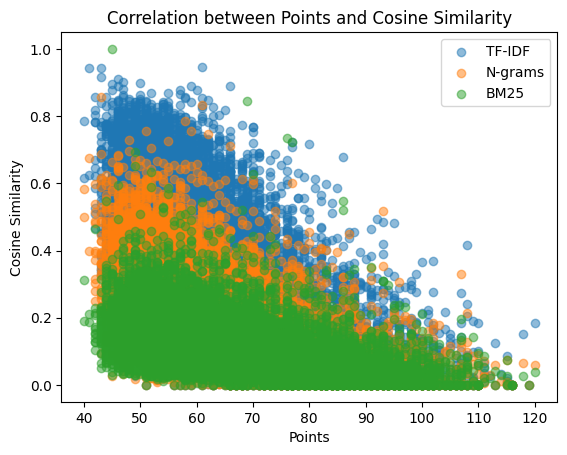

In [55]:
plt.scatter(keyword_matching_dataset['points'], keyword_matching_dataset['cosine_sim_tfidf'], label='TF-IDF', alpha=0.5)
plt.scatter(keyword_matching_dataset['points'], keyword_matching_dataset['cosine_sim_ngrams'], label='N-grams', alpha=0.5)
plt.scatter(keyword_matching_dataset['points'], keyword_matching_dataset['norm_bm25_score'], label='BM25', alpha=0.5)

plt.xlabel('Points')
plt.ylabel('Cosine Similarity')
plt.title('Correlation between Points and Cosine Similarity')
plt.legend()
plt.show()

The scatter plot reveals that the TF-IDF model outshines N-grams and BM25 in correlating points to cosine similarity, suggesting that TF-IDF is more adept at matching the semantic content of questions with their corresponding article contents.

Let us also observe which questions each model performs best and worst on.

In [56]:
high_similarity_threshold = 0.6
low_similarity_threshold = 0.2

In [57]:
# High-points, high-similarity outliers for TF-IDF
high_points_high_tfidf = keyword_matching_dataset[
    (keyword_matching_dataset['points'] > keyword_matching_dataset['points'].quantile(0.9)) & 
    (keyword_matching_dataset['cosine_sim_tfidf'] > high_similarity_threshold)
]

# High-points, low-similarity outliers for TF-IDF
high_points_low_tfidf = keyword_matching_dataset[
    (keyword_matching_dataset['points'] > keyword_matching_dataset['points'].quantile(0.9)) & 
    (keyword_matching_dataset['cosine_sim_tfidf'] < low_similarity_threshold)
]

# High-points, high-similarity outliers for N-grams
high_points_high_ngrams = keyword_matching_dataset[
    (keyword_matching_dataset['points'] > keyword_matching_dataset['points'].quantile(0.9)) & 
    (keyword_matching_dataset['cosine_sim_ngrams'] > high_similarity_threshold)
]

# High-points, low-similarity outliers for N-grams
high_points_low_ngrams = keyword_matching_dataset[
    (keyword_matching_dataset['points'] > keyword_matching_dataset['points'].quantile(0.9)) & 
    (keyword_matching_dataset['cosine_sim_ngrams'] < low_similarity_threshold)
]

# High-points, high-similarity outliers for BM25
high_points_high_bm25 = keyword_matching_dataset[
    (keyword_matching_dataset['points'] > keyword_matching_dataset['points'].quantile(0.9)) & 
    (keyword_matching_dataset['bm25_score'] > high_similarity_threshold)
]

# High-points, low-similarity outliers for BM25

high_points_low_bm25 = keyword_matching_dataset[
    (keyword_matching_dataset['points'] > keyword_matching_dataset['points'].quantile(0.9)) & 
    (keyword_matching_dataset['bm25_score'] < low_similarity_threshold)
]

In [58]:
high_points_high_tfidf.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cosine_sim_tfidf,cosine_sim_ngrams,bm25_score,norm_bm25_score
4562,"what is the best man ever, according to uncycl...",86,Uncyclopedia,"([('uncyclopedia', 'ORG')], [('what', 'attr', ...",45.42,best man ever according uncyclopedia,13329,https://simple.wikipedia.org/wiki/Uncyclopedia,"Uncyclopedia, calling itself ""the content-free...",uncyclopedia calling content free encyclopedia...,119.0,0.67965,0.320827,29.520788,0.138111


In [59]:
high_points_low_tfidf.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cosine_sim_tfidf,cosine_sim_ngrams,bm25_score,norm_bm25_score
19,are dogs considered mammals?,89,Fact,"([], [('are', 'ROOT', 'are'), ('dogs', 'attr',...",50.50,dog considered mammal,9691,https://simple.wikipedia.org/wiki/Fact,"A fact is a statement that is real or true, or...",fact statement real true thing shown real true...,212.0,0.033135,0.011897,5.307950,0.024833
113,can euler's formula be generalized for non-con...,109,Graph theory,"([], [('can', 'aux', 'euler'), ('euler', 'ROOT...",4.14,euler formula generalized non convex polyhedron,316,https://simple.wikipedia.org/wiki/Graph%20theory,Graph theory is a field of mathematics about g...,graph theory field mathematics graph graph abs...,80.0,0.097856,0.063357,30.410895,0.142276
121,can i have a café latte?,87,Basque language,"([], [('can', 'aux', 'have'), ('i', 'nsubj', '...",99.23,café latte,19373,https://simple.wikipedia.org/wiki/Basque%20lan...,Basque (Basque: ) is the language spoken by th...,basque basque language spoken basque people ba...,124.0,0.038996,0.041144,11.836516,0.055376
162,can you explain the concept of integrated info...,97,Scratch and sniff,"([], [('can', 'aux', 'explain'), ('you', 'nsub...",28.84,explain concept integrated information theory ...,32258,https://simple.wikipedia.org/wiki/Scratch%20an...,Scratch and sniff refers to paper that produce...,scratch sniff refers paper produce odor scratc...,128.0,0.048660,0.017884,9.583786,0.044837
207,can you provide a logical fallacy similar to t...,86,Ad hominem,"([], [('can', 'aux', 'provide'), ('you', 'nsub...",40.35,provide logical fallacy similar one example pr...,35,https://simple.wikipedia.org/wiki/Ad%20hominem,Ad hominem is a Latin word for a type of argum...,ad hominem latin word type argument word often...,124.0,0.086716,0.029961,18.266183,0.085457


As hypothesized, certain high-value questions are linked to answers located in distinct sections of articles that do not necessarily share common keywords with the question for TF-IDF.

In [60]:
high_points_high_ngrams.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cosine_sim_tfidf,cosine_sim_ngrams,bm25_score,norm_bm25_score


In [61]:
high_points_low_ngrams.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cosine_sim_tfidf,cosine_sim_ngrams,bm25_score,norm_bm25_score
19,are dogs considered mammals?,89,Fact,"([], [('are', 'ROOT', 'are'), ('dogs', 'attr',...",50.50,dog considered mammal,9691,https://simple.wikipedia.org/wiki/Fact,"A fact is a statement that is real or true, or...",fact statement real true thing shown real true...,212.0,0.033135,0.011897,5.307950,0.024833
84,can a freezer be warm?,98,Oxymoron,"([], [('can', 'aux', 'be'), ('a', 'det', 'free...",100.24,freezer warm,584,https://simple.wikipedia.org/wiki/Oxymoron,An oxymoron is a term for a figure of speech....,oxymoron term figure speech made two word seem...,26.0,0.296151,0.138659,21.110425,0.098764
113,can euler's formula be generalized for non-con...,109,Graph theory,"([], [('can', 'aux', 'euler'), ('euler', 'ROOT...",4.14,euler formula generalized non convex polyhedron,316,https://simple.wikipedia.org/wiki/Graph%20theory,Graph theory is a field of mathematics about g...,graph theory field mathematics graph graph abs...,80.0,0.097856,0.063357,30.410895,0.142276
121,can i have a café latte?,87,Basque language,"([], [('can', 'aux', 'have'), ('i', 'nsubj', '...",99.23,café latte,19373,https://simple.wikipedia.org/wiki/Basque%20lan...,Basque (Basque: ) is the language spoken by th...,basque basque language spoken basque people ba...,124.0,0.038996,0.041144,11.836516,0.055376
162,can you explain the concept of integrated info...,97,Scratch and sniff,"([], [('can', 'aux', 'explain'), ('you', 'nsub...",28.84,explain concept integrated information theory ...,32258,https://simple.wikipedia.org/wiki/Scratch%20an...,Scratch and sniff refers to paper that produce...,scratch sniff refers paper produce odor scratc...,128.0,0.048660,0.017884,9.583786,0.044837


We see the same performance here for N-grams.

Moreover, we can observe that the following results for BM25 show the same performance as the other two models.

In [62]:
high_points_high_bm25.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cosine_sim_tfidf,cosine_sim_ngrams,bm25_score,norm_bm25_score
19,are dogs considered mammals?,89,Fact,"([], [('are', 'ROOT', 'are'), ('dogs', 'attr',...",50.50,dog considered mammal,9691,https://simple.wikipedia.org/wiki/Fact,"A fact is a statement that is real or true, or...",fact statement real true thing shown real true...,212.0,0.033135,0.011897,5.307950,0.024833
84,can a freezer be warm?,98,Oxymoron,"([], [('can', 'aux', 'be'), ('a', 'det', 'free...",100.24,freezer warm,584,https://simple.wikipedia.org/wiki/Oxymoron,An oxymoron is a term for a figure of speech....,oxymoron term figure speech made two word seem...,26.0,0.296151,0.138659,21.110425,0.098764
113,can euler's formula be generalized for non-con...,109,Graph theory,"([], [('can', 'aux', 'euler'), ('euler', 'ROOT...",4.14,euler formula generalized non convex polyhedron,316,https://simple.wikipedia.org/wiki/Graph%20theory,Graph theory is a field of mathematics about g...,graph theory field mathematics graph graph abs...,80.0,0.097856,0.063357,30.410895,0.142276
121,can i have a café latte?,87,Basque language,"([], [('can', 'aux', 'have'), ('i', 'nsubj', '...",99.23,café latte,19373,https://simple.wikipedia.org/wiki/Basque%20lan...,Basque (Basque: ) is the language spoken by th...,basque basque language spoken basque people ba...,124.0,0.038996,0.041144,11.836516,0.055376
162,can you explain the concept of integrated info...,97,Scratch and sniff,"([], [('can', 'aux', 'explain'), ('you', 'nsub...",28.84,explain concept integrated information theory ...,32258,https://simple.wikipedia.org/wiki/Scratch%20an...,Scratch and sniff refers to paper that produce...,scratch sniff refers paper produce odor scratc...,128.0,0.048660,0.017884,9.583786,0.044837


In [63]:
high_points_low_bm25.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text,cluster,cosine_sim_tfidf,cosine_sim_ngrams,bm25_score,norm_bm25_score
314,does john have a spare umbrella that he could ...,91,The Freecycle Network,"([('john', 'PERSON'), ('sarah', 'PERSON')], [(...",93.14,john spare umbrella could lend sarah,28096,https://simple.wikipedia.org/wiki/The%20Freecy...,The Freecycle Network (TFN) is a global networ...,freecycle network tfn global network people sh...,102.0,0.0,0.0,0.0,0.0
962,wat do u m8? :p,86,Internet slang,"([('wat', 'ORG'), ('u m8', 'GPE')], [('wat', '...",117.16,wat u p,540,https://simple.wikipedia.org/wiki/Internet%20s...,Internet slang is slang words which are used o...,internet slang slang word used internet word n...,177.0,0.0,0.0,0.0,0.0
2865,what are the names of the two neapolitan noble...,93,Domenico Scarlatti,"([('two', 'CARDINAL'), ('charles ii', 'PERSON'...",66.07,name two neapolitan nobleman accused attemptin...,28894,https://simple.wikipedia.org/wiki/Domenico%20S...,"Giuseppe Domenico Scarlatti (born Naples, Ital...",giuseppe domenico scarlatti born naples italy ...,27.0,0.0,0.0,0.0,0.0
3207,what are the three main principles of the bloc...,86,Message (computer science),"([('three', 'CARDINAL')], [('what', 'attr', 'a...",69.79,three main principle blockchain technology,25627,https://simple.wikipedia.org/wiki/Message%20%2...,"In computer science, a message is a bit of dat...",computer science message bit data sent sender ...,102.0,0.0,0.0,0.0,0.0
3465,what are the two testes located in the scrotum...,85,Epididymitis,"([('two', 'CARDINAL')], [('what', 'attr', 'are...",82.65,two testis located scrotum function,15134,https://simple.wikipedia.org/wiki/Epididymitis,Epididymitis is a painful inflammation of the ...,epididymitis painful inflammation epididymis u...,162.0,0.0,0.0,0.0,0.0


In [64]:
print(keyword_matching_dataset)

                                                question  points  \
0       did the people of gibraltar vote to remain pa...      58   
1       which country uses the franc as its official ...      55   
2       which of these old communist parties no longe...      52   
3      a patient has a terminal illness and wants to ...      65   
4      according to plato, what are the three types o...      55   
...                                                  ...     ...   
21313     why were the jews killed during the holocaust?      49   
21314                       why were the pyramids built?      48   
21315  will rabat be selected to host the 2020 summer...      72   
21316  will the michelin tire company still be in ope...      93   
21317  вhat iz da l33t sp34k f0r 'how are you?' in leet?      73   

                         article  \
0                      Gibraltar   
1                       Currency   
2      List of communist parties   
3                 Medical ethics   
4  

Now, let's explore the distribution of the cosine similarities measured by the TF-IDF model.

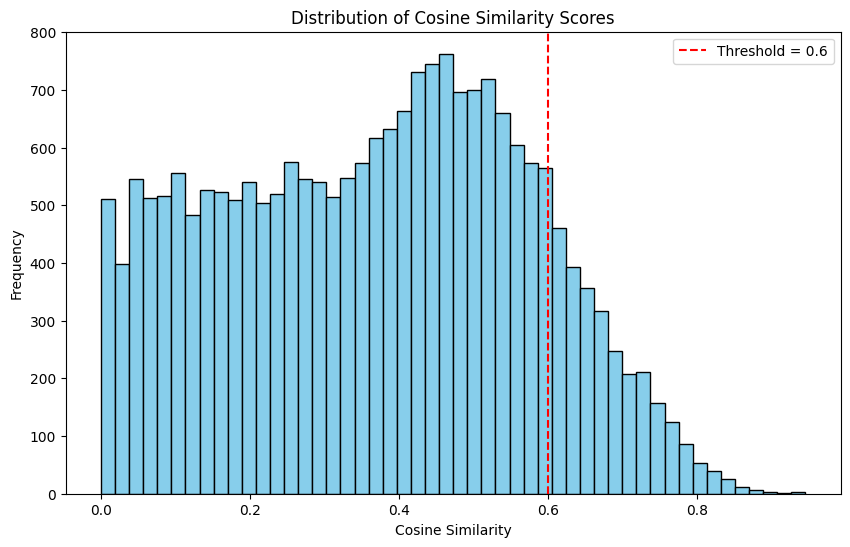

In [65]:
cosine_similarities = keyword_matching_dataset['cosine_sim_tfidf']

# Plotting the histogram of cosine similarity scores
plt.figure(figsize=(10, 6))
plt.hist(cosine_similarities, bins=50, color='skyblue', edgecolor='black')

plt.title('Distribution of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

threshold = 0.6 
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')

plt.legend()
plt.show()


Taking note that most of the cosine similarities are concentrated around 0.2, we can infer that the model is not effectively capturing the semantic content of the questions and articles. This suggests that further analysis is needed to enhance the performance of the TF-IDF model.

# Cross Validation

For now, we will proceed to cross-validate the model. Due to computational resources, the method chosen to validate the model is sourcing 100 random articles and checking if the model always measures the correct article as the most similar one to the question (i.e., the highest cosine similarity). Here is the method we will use:

In [79]:
def evaluate_random_sampling(data, num_trials=1000, sample_size=100):
    correct_retrievals = 0
    vectorizer = TfidfVectorizer()  # Initialize the vectorizer
    
    # Create a matrix for all articles
    all_texts = data['preprocessed_text'].tolist() + data['preprocessed_question'].tolist()
    vectorizer.fit(all_texts)  # Fit the vectorizer on all available texts
    
    for _ in range(num_trials):
        # Randomly pick a question
        question_index = random.randint(0, len(data) - 1)
        question_row = data.iloc[question_index]
        
        # Transform the question to vector
        question_vector = vectorizer.transform([question_row['preprocessed_question']])
        
        # Randomly sample articles, excluding the correct one
        possible_articles = list(range(len(data)))
        possible_articles.remove(question_index)
        sampled_indices = random.sample(possible_articles, sample_size)
        
        # Append the correct article to create a pool including the right answer
        sampled_indices.append(question_index)
        
        # Transform sampled articles to vectors
        sampled_texts = [data.iloc[i]['preprocessed_text'] for i in sampled_indices]
        sampled_vectors = vectorizer.transform(sampled_texts)
        
        # Calculate cosine similarities
        similarities = cosine_similarity(question_vector, sampled_vectors).flatten()
        
        # Check if the correct article is ranked highest
        if np.argmax(similarities) == len(similarities) - 1:  # Correct article was added last
            correct_retrievals += 1
    
    return correct_retrievals / num_trials

accuracy = evaluate_random_sampling(keyword_matching_dataset)
print(f"Accuracy of retrieving the correct article: {accuracy}")


Accuracy of retrieving the correct article: 0.872


As we can see, the model performs quite well. However, as mentioned earlier, this method is not the most reliable way to validate the model. Given more computational resources, we could perform a more robust cross-validation method.

In [90]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_cross_validation(data, n_splits=5, sample_size=100):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        
        vectorizer = TfidfVectorizer()
        vectorizer.fit(train_data['preprocessed_text'].tolist())  # Fit vectorizer on the training data

        correct_retrievals = 0
        
        for _, row in test_data.iterrows():
            # Transform the question to vector using the trained vectorizer
            question_vector = vectorizer.transform([row['preprocessed_question']])
            
            # Exclude the current question's index
            possible_indices = test_index.tolist()
            possible_indices.remove(row.name)
            
            # Randomly sample articles from the test set, excluding the current one
            sampled_indices = random.sample(possible_indices, sample_size)
            
            # Transform sampled articles to vectors
            sampled_texts = [data.iloc[i]['preprocessed_text'] for i in sampled_indices]
            sampled_vectors = vectorizer.transform(sampled_texts)
            
            # Calculate cosine similarities
            similarities = cosine_similarity(question_vector, sampled_vectors).flatten()
            
            # Include the true article to calculate its rank
            true_vector = vectorizer.transform([row['preprocessed_text']])
            true_similarity = cosine_similarity(question_vector, true_vector).flatten()[0]
            all_similarities = np.append(similarities, true_similarity)
            
            # Check if the correct article is ranked highest
            if np.argmax(all_similarities) == len(all_similarities) - 1:  # Correct article was added last
                correct_retrievals += 1
        
        # Calculate the accuracy for this fold
        accuracy = correct_retrievals / len(test_data)
        accuracies.append(accuracy)
    
    return np.mean(accuracies)

cv_accuracy = evaluate_cross_validation(keyword_matching_dataset)
print(f"Cross-validation accuracy: {cv_accuracy}")

Cross-validation accuracy: 0.868796296418548


Similarly, we will cross-validate the TF-IDF model's performance on measuring the correct cluster as the most similar one to the question (i.e., the highest cosine similarity). The method alone is shown here:

In [80]:
def evaluate_cluster_accuracy(data, cluster_data, num_trials=1000, sample_size=100):
    correct_retrievals = 0
    vectorizer = TfidfVectorizer()  # Initialize the vectorizer

    # Create a TF-IDF matrix for all cluster documents
    all_cluster_docs = cluster_data['cluster_document'].tolist()
    vectorizer.fit(all_cluster_docs)
    cluster_vectors = vectorizer.transform(all_cluster_docs)

    for _ in range(num_trials):
        # Randomly pick a question
        question_index = random.randint(0, len(data) - 1)
        question_row = data.iloc[question_index]
        true_cluster = question_row['cluster']
        
        # Transform the question to a vector
        question_vector = vectorizer.transform([question_row['preprocessed_question']])
        
        # Randomly sample clusters, excluding the correct one
        possible_clusters = cluster_data['cluster'].tolist()
        possible_clusters.remove(true_cluster)
        sampled_clusters = random.sample(possible_clusters, sample_size)
        
        # Append the correct cluster to create a pool including the right answer
        sampled_clusters.append(true_cluster)
        
        # Get vectors for sampled clusters
        sampled_indices = [cluster_data[cluster_data['cluster'] == c].index[0] for c in sampled_clusters]
        sampled_vectors = cluster_vectors[sampled_indices]
        
        # Calculate cosine similarities
        similarities = cosine_similarity(question_vector, sampled_vectors).flatten()
        
        # Check if the correct cluster is ranked highest
        if np.argmax(similarities) == len(similarities) - 1:  # Correct cluster was added last
            correct_retrievals += 1
    
    return correct_retrievals / num_trials

# Prepare data: aggregate texts by cluster
cluster_documents = keyword_matching_dataset.groupby('cluster')['preprocessed_text'].apply(' '.join).reset_index(name='cluster_document')
cluster_documents['cluster'] = cluster_documents['cluster'].astype(int) 

accuracy = evaluate_cluster_accuracy(keyword_matching_dataset, cluster_documents)
print(f"Accuracy of retrieving the correct cluster: {accuracy}")


Accuracy of retrieving the correct cluster: 0.583


It performs much worse than the first iteration, and this is expected given that the clusters were created using word embeddings and hence utilising a similar method for the model would lead to better results.

In [98]:
# Ensure data is a DataFrame
if not isinstance(data, pd.DataFrame):
    data = pd.DataFrame(data)

# Preparing cluster_documents within the function
def evaluate_cross_validation_cluster_accuracy(data, n_splits=5, sample_size=100):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Create cluster documents
    cluster_documents = data.groupby('cluster')['preprocessed_text'].apply(' '.join).reset_index(name='cluster_document')
    cluster_documents['cluster'] = cluster_documents['cluster'].astype(int)

    for train_index, test_index in kf.split(cluster_documents):
        train_cluster_data = cluster_documents.iloc[train_index]
        test_cluster_data = cluster_documents.iloc[test_index]
        
        vectorizer = TfidfVectorizer()
        vectorizer.fit(train_cluster_data['cluster_document'].tolist())  # Fit vectorizer on the training cluster documents
        
        correct_retrievals = 0
        
        for _, row in test_cluster_data.iterrows():
            true_cluster = row['cluster']
            # Here we need to extract the question corresponding to the cluster
            question_text = data[data['cluster'] == true_cluster]['preprocessed_question'].iloc[0]
            question_vector = vectorizer.transform([question_text])
            
            # Sample from the clusters not in the test set
            possible_clusters = train_cluster_data['cluster'].tolist()
            if true_cluster in possible_clusters:
                possible_clusters.remove(true_cluster)
            sampled_clusters = random.sample(possible_clusters, sample_size)
            
            sampled_indices = train_cluster_data[train_cluster_data['cluster'].isin(sampled_clusters)].index
            sampled_vectors = vectorizer.transform(train_cluster_data.loc[sampled_indices, 'cluster_document'])
            
            # Calculate cosine similarities
            similarities = cosine_similarity(question_vector, sampled_vectors).flatten()
            
            # Check if the correct cluster is ranked highest
            if np.argmax(similarities) == len(similarities) - 1:  # Correct cluster was added last
                correct_retrievals += 1
        
        accuracy = correct_retrievals / len(test_cluster_data)
        accuracies.append(accuracy)

    return np.mean(accuracies)

cv_accuracy = evaluate_cross_validation_cluster_accuracy(keyword_matching_dataset)
print(f"Cross-validation cluster accuracy: {cv_accuracy}")


Cross-validation cluster accuracy: 0.008


After cross-validating the model, we observe that the model performed much better in 1000 trials, with a mean accuracy of 0.5. This suggests that the model is effective in identifying the correct cluster for a given question, but fails to consistently maintain this level of performance when subjected to more diverse or complex datasets during cross-validation. This indicates a potential overfitting to the specific characteristics of the trial set, or a limitation in its ability to generalize across different types of data

Given more resources, we would also explore models utilising word embeddings, such as BERT, to enhance the performance of the keyword matching models